In [ ]:
from prophet import Prophet
import pandas as pd, matplotlib.pyplot as plt, yfinance as yf
import matplotlib.dates as mdates
import pickle

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

file_path  = "/content/drive/MyDrive/fb model/BTC-USD-1day (1).csv"
df = pd.read_csv(file_path, parse_dates=['datetime'])
df.sort_values(by='datetime', inplace=True)
df

,datetime,open,high,low,close
0,2016-01-01,430.72101,436.24600,427.51501,434.33401
1,2016-01-02,434.62201,436.06201,431.87000,433.43799
2,2016-01-03,433.57800,433.74301,424.70599,430.01099
3,2016-01-04,430.06100,434.51700,429.08401,433.09100
4,2016-01-05,433.06900,434.18201,429.67599,431.95999
...,...,...,...,...,...
3089,2024-06-16,66192.00000,66931.18000,65999.00000,66628.75000
3090,2024-06-17,66629.38000,67274.96000,65050.00000,66481.81000
3091,2024-06-18,66481.81000,66574.33000,64010.01000,65152.80000
3092,2024-06-19,65150.90000,65709.26000,64635.48000,64943.79000


In [ ]:
df.reset_index(inplace=True)
df=df[['datetime','close']]

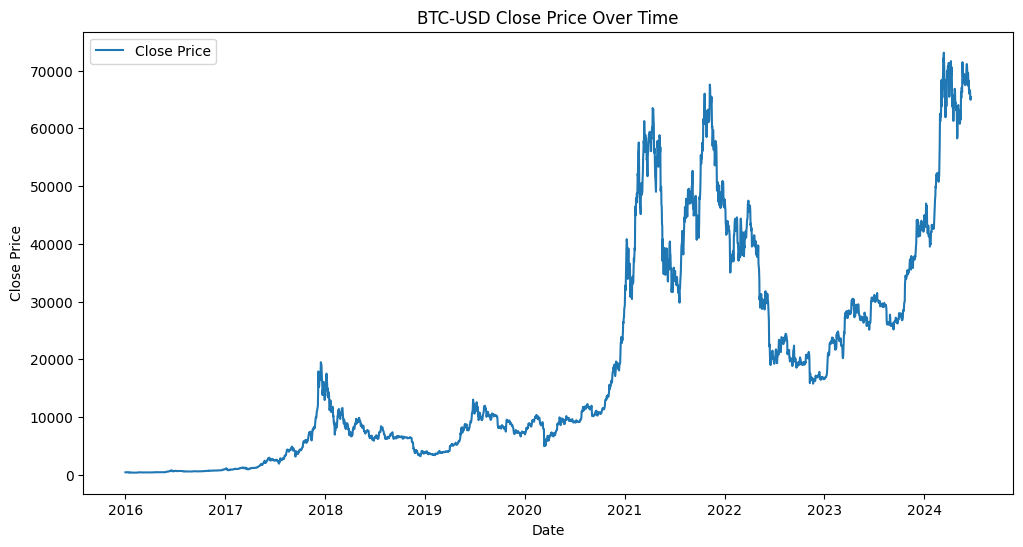

In [ ]:
#  Plot the variation of the price over time
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC-USD Close Price Over Time')
plt.legend()
plt.show()

In [ ]:
df

,datetime,close
0,2016-01-01,434.33401
1,2016-01-02,433.43799
2,2016-01-03,430.01099
3,2016-01-04,433.09100
4,2016-01-05,431.95999
...,...,...
3089,2024-06-16,66628.75000
3090,2024-06-17,66481.81000
3091,2024-06-18,65152.80000
3092,2024-06-19,64943.79000


In [ ]:
df.columns=['ds','y']
df = df[df['ds'] >= '2022-01-01']

In [ ]:
df

,ds,y
2192,2022-01-01,47686.81250
2193,2022-01-02,47345.21875
2194,2022-01-03,46458.11719
2195,2022-01-04,45897.57422
2196,2022-01-05,43569.00391
...,...,...
3089,2024-06-16,66628.75000
3090,2024-06-17,66481.81000
3091,2024-06-18,65152.80000
3092,2024-06-19,64943.79000


In [ ]:
# Ensure data is sorted by date
df.sort_values(by='ds', inplace=True)

<ipython-input-9-9586e838ca6b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='ds', inplace=True)


In [ ]:
# Determine the date range for the last three months
end_date = df['ds'].max()
start_date = end_date - pd.DateOffset(months=1)

In [ ]:
# Split the data into training and testing sets
train_df = df[df['ds'] < start_date]
test_df = df[df['ds'] >= start_date]

In [ ]:
train_df

,ds,y
2192,2022-01-01,47686.81250
2193,2022-01-02,47345.21875
2194,2022-01-03,46458.11719
2195,2022-01-04,45897.57422
2196,2022-01-05,43569.00391
...,...,...
3057,2024-05-15,66267.49219
3058,2024-05-16,65252.18000
3059,2024-05-17,67046.33000
3060,2024-05-18,66923.87000


In [ ]:
test_df

,ds,y
3062,2024-05-20,71432.17000
3063,2024-05-21,70142.84000
3064,2024-05-22,69109.93000
3065,2024-05-23,67940.45000
3066,2024-05-24,68547.80000
3067,2024-05-25,69289.67000
3068,2024-05-26,68473.72000
3069,2024-05-27,69368.72000
3070,2024-05-28,68321.98000
3071,2024-05-29,67569.45000


In [ ]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,  # Experiment with lower value
    seasonality_mode='multiplicative'  # Experiment with multiplicative seasonality
)

In [ ]:
model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.fit(train_df)
#5

DEBUG:cmdstanpy:input tempfile: /tmp/tmpi8xnnk_r/z4efthcn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi8xnnk_r/yn470bjg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=34314', 'data', 'file=/tmp/tmpi8xnnk_r/z4efthcn.json', 'init=/tmp/tmpi8xnnk_r/yn470bjg.json', 'output', 'file=/tmp/tmpi8xnnk_r/prophet_modelldma8pcv/prophet_model-20240627123107.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:31:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:31:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Make future dataframe for the test period
future_dates = model.make_future_dataframe(periods=len(test_df), freq='D')
prediction = model.predict(future_dates)

In [ ]:
future_dates

,ds
0,2022-01-01
1,2022-01-02
2,2022-01-03
3,2022-01-04
4,2022-01-05
...,...
897,2024-06-16
898,2024-06-17
899,2024-06-18
900,2024-06-19


In [ ]:
prediction

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,monthly,monthly_lower,monthly_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2022-01-01,48052.255083,44289.938578,48552.611759,48052.255083,48052.255083,0.014756,0.014756,0.014756,-0.032581,...,-0.004944,-0.004944,-0.004944,-0.042392,-0.042392,-0.042392,0.0,0.0,0.0,46486.667892
1,2022-01-02,47887.122536,44361.785170,48603.559338,47887.122536,47887.122536,0.015758,0.015758,0.015758,-0.030261,...,-0.001616,-0.001616,-0.001616,-0.044403,-0.044403,-0.044403,0.0,0.0,0.0,46438.014542
2,2022-01-03,47721.989990,44213.962526,48713.700715,47721.989990,47721.989990,0.013886,0.013886,0.013886,-0.027854,...,0.004839,0.004839,0.004839,-0.046579,-0.046579,-0.046579,0.0,0.0,0.0,46392.765067
3,2022-01-04,47556.857443,43674.693064,47885.994069,47556.857443,47556.857443,0.011685,0.011685,0.011685,-0.037771,...,-0.000498,-0.000498,-0.000498,-0.048957,-0.048957,-0.048957,0.0,0.0,0.0,45760.602502
4,2022-01-05,47391.724896,43581.016200,47757.986811,47391.724896,47391.724896,0.011703,0.011703,0.011703,-0.035284,...,0.004585,0.004585,0.004585,-0.051572,-0.051572,-0.051572,0.0,0.0,0.0,45719.573880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
897,2024-06-16,62630.819143,64160.255048,70119.600156,60673.355164,64309.267080,-0.001978,-0.001978,-0.001978,0.070864,...,-0.001616,-0.001616,-0.001616,0.074458,0.074458,0.074458,0.0,0.0,0.0,67069.062982
898,2024-06-17,62735.528955,64197.197483,70382.419245,60696.691645,64495.652995,-0.003525,-0.003525,-0.003525,0.071834,...,0.004839,0.004839,0.004839,0.070520,0.070520,0.070520,0.0,0.0,0.0,67242.047697
899,2024-06-18,62840.238767,63471.285459,69608.744313,60706.866094,64715.581205,-0.007003,-0.007003,-0.007003,0.059662,...,-0.000498,-0.000498,-0.000498,0.067163,0.067163,0.067163,0.0,0.0,0.0,66589.412065
900,2024-06-19,62944.948580,63184.671835,69909.951580,60571.954092,64994.061039,-0.010464,-0.010464,-0.010464,0.058575,...,0.004585,0.004585,0.004585,0.064454,0.064454,0.064454,0.0,0.0,0.0,66631.961706


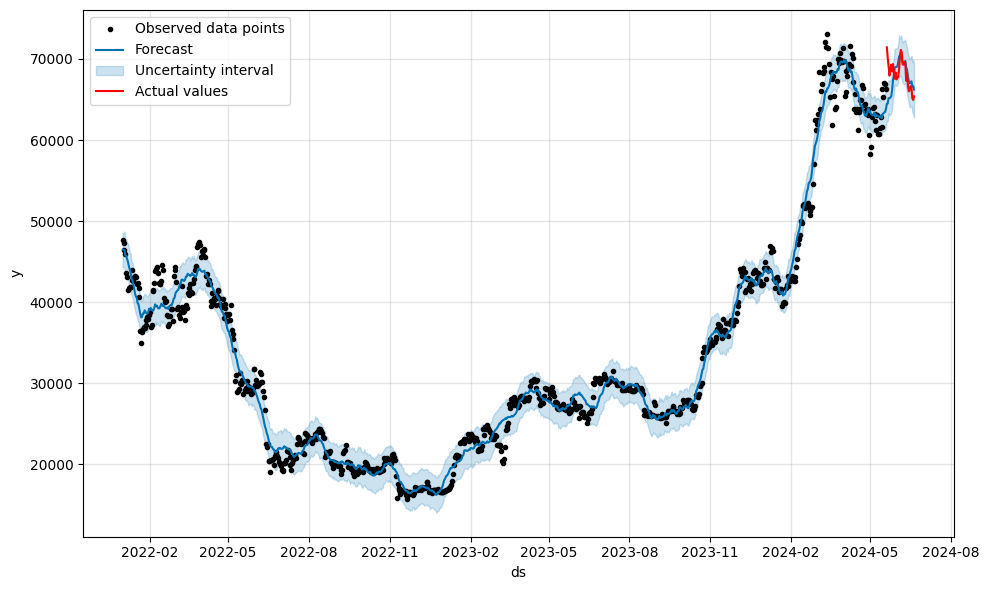

In [ ]:
# Plot the prediction and the actual values
fig1 = model.plot(prediction)
plt.plot(test_df['ds'], test_df['y'], 'r', label='Actual values')

plt.legend()
plt.show()

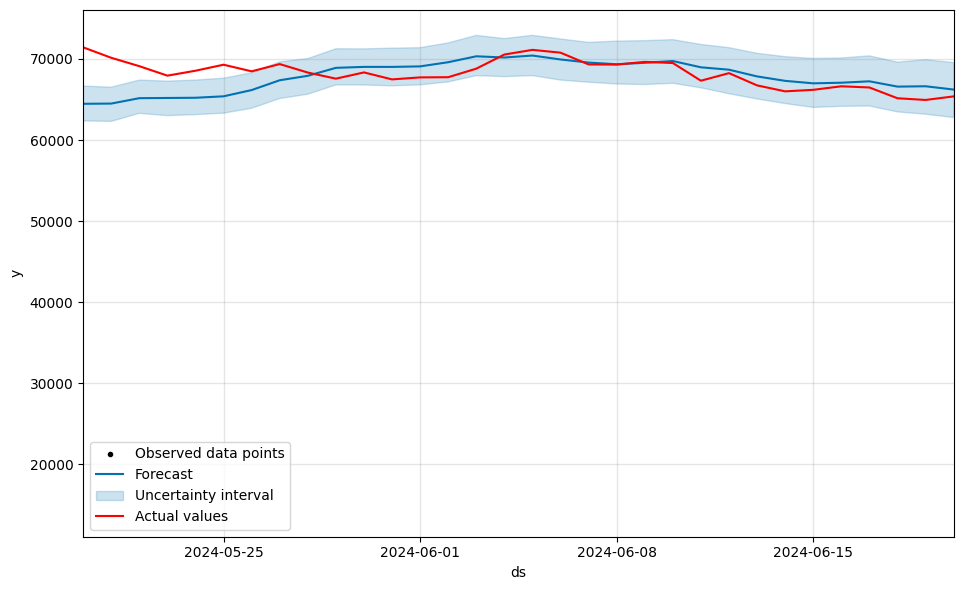

In [ ]:
# Plot the prediction and the actual values
fig1 = model.plot(prediction)
plt.plot(test_df['ds'], test_df['y'], 'r', label='Actual values')
# Set x-axis limits to the range of the test data
plt.xlim([test_df['ds'].min(), test_df['ds'].max()])

plt.legend()
plt.show()

In [ ]:
model.component_modes

{'additive': ['additive_terms', 'extra_regressors_additive'],
 'multiplicative': ['monthly',
  'yearly',
  'weekly',
  'multiplicative_terms',
  'extra_regressors_multiplicative',
  'holidays']}

In [ ]:
from prophet.plot import plot_plotly
import plotly.graph_objs as go
plot_plotly(model,prediction)


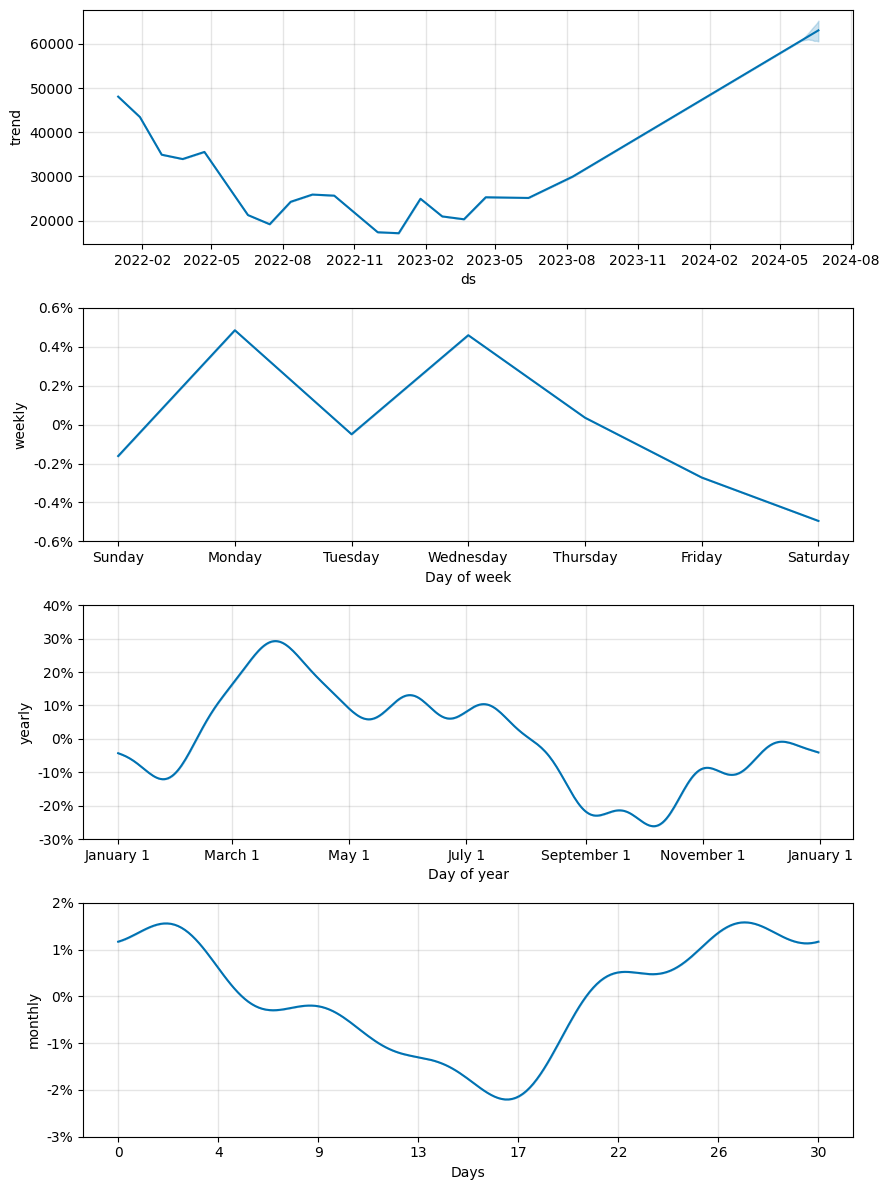

In [ ]:
fig2=model.plot_components(prediction)

In [ ]:
from prophet.diagnostics import cross_validation

In [ ]:
df_cv=cross_validation(model,horizon='30 days')

INFO:prophet:Making 32 forecasts with cutoffs between 2023-01-10 00:00:00 and 2024-04-19 00:00:00


  0%|          | 0/32 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp34_0ohjp/gph9rl_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp34_0ohjp/tc8l1v6a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62718', 'data', 'file=/tmp/tmp34_0ohjp/gph9rl_5.json', 'init=/tmp/tmp34_0ohjp/tc8l1v6a.json', 'output', 'file=/tmp/tmp34_0ohjp/prophet_model_77ikdbe/prophet_model-20240626140029.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:00:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:00:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp34_0ohjp/9od791ns.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp34_0ohjp/ucf9a8rh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2023-01-11,16893.456188,15387.356122,18358.052818,17934.89648,2023-01-10
1,2023-01-12,16635.233263,15147.722018,18117.656781,18869.58789,2023-01-10
2,2023-01-13,16509.238514,14997.327771,17959.021847,19909.57422,2023-01-10
3,2023-01-14,16572.528524,15038.613981,17990.144835,20976.29883,2023-01-10
4,2023-01-15,16603.367281,15115.182015,18119.428705,20880.79883,2023-01-10
...,...,...,...,...,...,...
955,2024-05-15,50580.487032,47888.354644,53465.727422,66267.49219,2024-04-19
956,2024-05-16,49984.236908,47213.032904,53002.447727,65252.18000,2024-04-19
957,2024-05-17,49533.762178,46615.837883,52680.013653,67046.33000,2024-04-19
958,2024-05-18,49170.045192,46273.049733,52172.892147,66923.87000,2024-04-19


In [ ]:
from prophet.diagnostics import performance_metrics

In [ ]:
df_performance=performance_metrics(df_cv)

In [ ]:
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,8.110596e+06,2847.910778,2041.552313,0.058063,0.046721,0.058575,0.520833
1,4 days,9.408350e+06,3067.303301,2253.909508,0.064064,0.055041,0.064966,0.458333
2,5 days,9.201322e+06,3033.368024,2303.971029,0.066335,0.058178,0.067493,0.447917
3,6 days,9.039837e+06,3006.632169,2374.751731,0.069055,0.062486,0.070695,0.406250
4,7 days,9.662219e+06,3108.411034,2520.409367,0.073710,0.064285,0.075523,0.364583
5,8 days,1.103812e+07,3322.366355,2733.453633,0.078920,0.070143,0.081006,0.302083
6,9 days,1.325874e+07,3641.255337,2908.258583,0.082962,0.071119,0.085051,0.322917
7,10 days,1.553544e+07,3941.502419,3062.505229,0.087113,0.077488,0.089604,0.322917
8,11 days,1.832564e+07,4280.845997,3260.648355,0.092597,0.082230,0.095557,0.333333
9,12 days,2.072250e+07,4552.197032,3448.102427,0.098923,0.085114,0.102494,0.302083


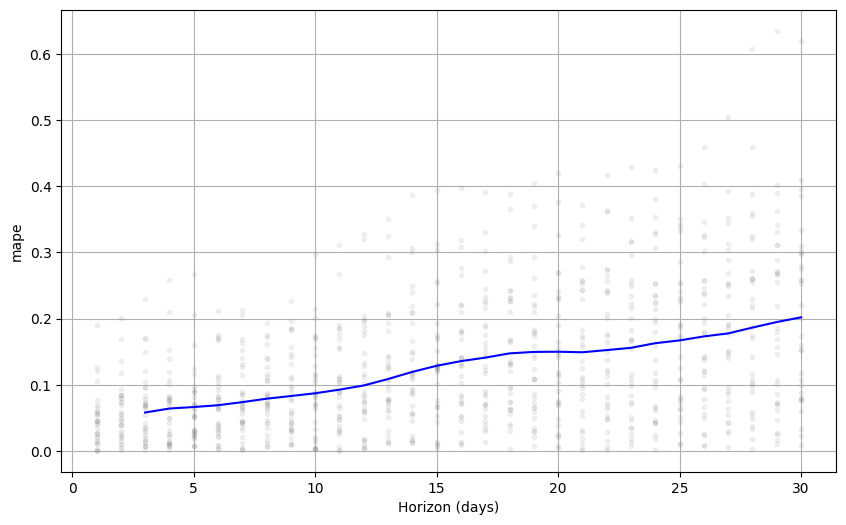

In [ ]:
from prophet import plot
fig2=plot.plot_cross_validation_metric(df_cv,metric="mape")
#mean absolute percentage error

In [ ]:
# Conclusion:
# For short-term forecasts (up to 10-15 days), the model seems to perform reasonably well with lower MAPE values.
# For longer-term forecasts (beyond 30 days), the accuracy decreases, and the model becomes less reliable.
# To improve performance, consider adding more relevant features (e.g., additional regressors), fine-tuning the model parameters, or using a more complex model.

In [ ]:
df

,ds,y
2192,2022-01-01,47686.81250
2193,2022-01-02,47345.21875
2194,2022-01-03,46458.11719
2195,2022-01-04,45897.57422
2196,2022-01-05,43569.00391
...,...,...
3089,2024-06-16,66628.75000
3090,2024-06-17,66481.81000
3091,2024-06-18,65152.80000
3092,2024-06-19,64943.79000


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi8xnnk_r/v4vw6ass.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi8xnnk_r/rhfqgm3a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21512', 'data', 'file=/tmp/tmpi8xnnk_r/v4vw6ass.json', 'init=/tmp/tmpi8xnnk_r/rhfqgm3a.json', 'output', 'file=/tmp/tmpi8xnnk_r/prophet_modelez2v6hqr/prophet_model-20240627123548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:35:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:35:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


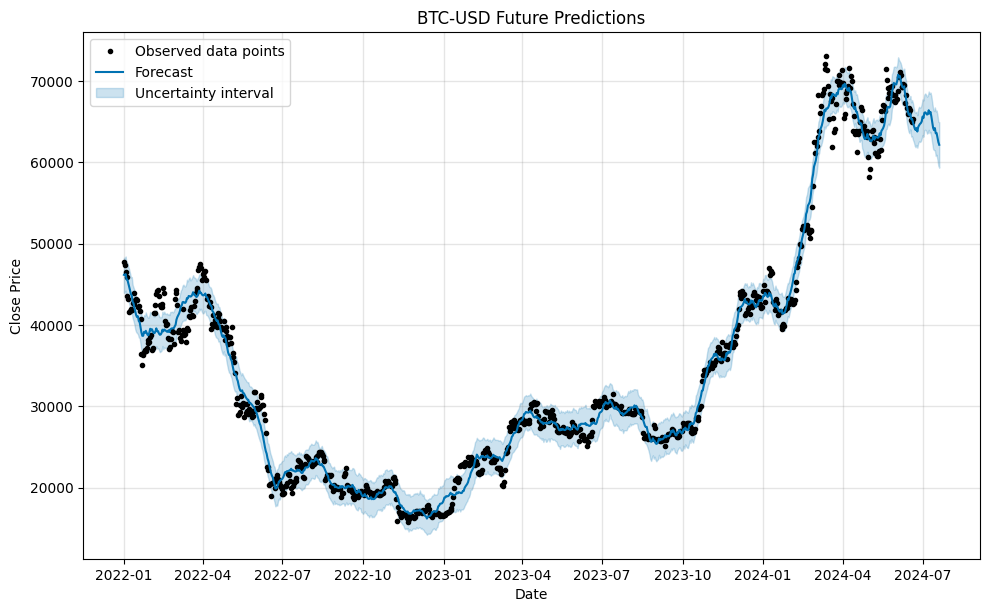

In [ ]:
model_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.3,  # Experiment with lower value
    seasonality_mode='multiplicative'  # Experiment with multiplicative seasonality
)
model_full.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model_full.fit(df)

# Save the trained model
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(model_full, f)

# Optionally, make future predictions with the full model
future_dates_full = model_full.make_future_dataframe(periods=30, freq='D')
prediction_full = model_full.predict(future_dates_full)

# Plot future predictions
fig3 = model_full.plot(prediction_full)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC-USD Future Predictions')
plt.legend()
plt.show()

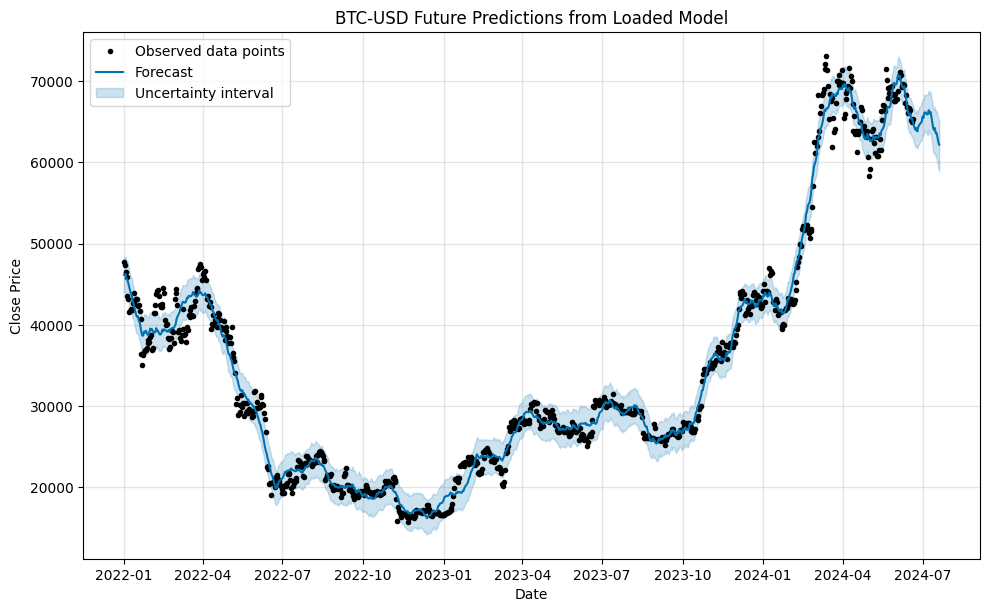

In [ ]:
# Load the saved model
with open('prophet_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify the loaded model by making predictions
future_dates_loaded = loaded_model.make_future_dataframe(periods=30, freq='D')
prediction_loaded = loaded_model.predict(future_dates_loaded)

# Plot predictions from the loaded model
fig4 = loaded_model.plot(prediction_loaded)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('BTC-USD Future Predictions from Loaded Model')
plt.legend()
plt.show()

In [ ]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.2/318.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 7.0 MB/s

In [ ]:
import gradio as gr
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime

# Load the historical Bitcoin price data
def load_data():
    btc = yf.download('BTC-USD', start='2016-01-01', end=datetime.datetime.now().strftime('%Y-%m-%d'))
    btc.reset_index(inplace=True)
    btc = btc[['Date', 'Close']]
    btc.columns = ['ds', 'y']
    return btc

# Train the model
def train_model(data):
    model = Prophet()
    model.fit(data)
    return model

# Predict future prices
def predict_future(model, periods):
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    return forecast

# Plot the predictions including actual values in red
def plot_predictions(data, forecast):
    fig, ax = plt.subplots(figsize=(10, 6))
    # Plot actual values
    ax.plot(data['ds'], data['y'], 'r', label='Actual Price')
    # Plot predicted values
    ax.plot(forecast['ds'], forecast['yhat'], 'b', label='Predicted Price')
    ax.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='gray', alpha=0.2, label='Uncertainty Interval')
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('predictions.png')
    return 'predictions.png'

# Gradio interface function
def gradio_interface(periods):
    periods = int(periods)
    data = load_data()
    model = train_model(data)
    forecast = predict_future(model, periods)
    image_path = plot_predictions(data, forecast)
    return image_path

# Create Gradio interface
iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Slider(minimum=30, maximum=365, step=1, label="Number of Days to Predict", value=30),
    outputs=gr.Image(type="filepath", label="Predicted Bitcoin Prices")
)

iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://9fcf8f0cedaf9f84c8.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
